In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
base_folder = Path(f"/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/") 

adata_file = base_folder / "data" / "cell_segmentation" / "concatenated" / "combined_adata.h5ad"
laina_results_dir = base_folder / "results" / "LIANA"

ST_sample = sc.read_h5ad(adata_file)
PTEN_list = ['35_LGIRT', '33_LGIRT', '37_CRRT', '31_RT', '34_LGIRT', '36_CRRT', '38_CRRT', '32_RT']
ST_sample = ST_sample[ST_sample.obs["mouse"].isin(PTEN_list)].copy()

In [3]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

X = ST_sample.layers["counts"] if "counts" in ST_sample.layers else ST_sample.X

# -----------------------------
# 1) Marker panels
# -----------------------------
# # Your existing panels
# m1_all = ['Ccl3','Ccl4','Ccl5','Cd40','Cxcl10','Cxcl9','Il1b','Il6','Irf1','Irf5','Nos2','Psmb9','Stat1','Tap1','Tnf']
# m2_all = ['Anxa1','Apoe','Arg1','Axl','C1qa','C1qb','C1qc','Chil3','Csf1r','Fn1','Gas6','Il10',
#           'Itgav','Itgb1','Lgals3','Lrp1','Mertk','Mrc1','Pros1','Retnla','Spp1','Tgfb1','Vegfa']

# # Core vs accessory (kept; added Cd80/Cd86/Ccr7 for M1 co-stim as you had; Cd163 moved to M2 core per your edit above)
# m1_core = ['Nos2','Il1b','Tnf','Stat1','Cxcl9','Cxcl10','Cd40']
# m1_acc  = sorted(list(set(m1_all) - set(m1_core)))

# m2_core = ['Mrc1','Arg1','Retnla','Chil3','Mertk','Axl','Csf1r','Apoe','Lrp1','Spp1']
# m2_acc  = sorted(list(set(m2_all) - set(m2_core)))

# # NEW: Monocyte identity panel (mouse symbols)
# # Classical (Ly6C+/CCR2+) & nonclassical (CX3CR1high/NR4A1+) — avoiding M2 macrophage markers.
# monocyte_panel = [
#     # Common monocyte / myeloid identity
#     'Ly6c2','Ccr2','Cd14','Fcgr1','Fcgr3','Itgam','Ms4a7','Spi1','Tyrobp','Fcer1g','Lst1',
#     'Lgals3','Ptprc','Tlr2','Tlr4','Coro1a','Lyz2','Lyz1',
#     # Nonclassical / patrolling signatures
#     'Cx3cr1','Nr4a1','Itgal'
# ]
# # Guards to EXCLUDE likely non-denominator populations
# neutro_guard = ['Ly6g','Mpo','Elane','Camp','Ltf','S100a8','S100a9']  # neutrophil-like
# dc_guard     = ['H2-Aa','H2-Ab1','H2-Eb1','Cd74','Itgax']            # dendritic-like


# --- M1 ---
m1_core = ['Nos2','Il1b','Tnf','Stat1','Irf1','Irf5','Cxcl9','Cxcl10','Cd40']
m1_acc  = ['Ccl3','Ccl4','Ccl5','Tap1','Psmb9','Gbp2','Gbp5','Ifit1','Ifit2','Isg15','Oas1a','Socs1',
           'Cd80','Cd86','Ccr7']

# --- M2 ---
m2_core = ['Mrc1','Arg1','Retnla','Chil3','Mertk','Stab1','Mgl2','Il10ra']
m2_acc  = ['Axl','Gas6','Lgals3','Apoe','Lrp1','Spp1','Csf1r','Tgfb1','Cd163',
           'Vegfa','Fn1','Itgb1','Itgav','Pros1','C1qa','C1qb','C1qc']

# --- Monocyte identity ---
monocyte_panel = ['Ly6c2','Ccr2','Sell','Plac8','Ms4a3','Cd14','Fcgr1','Fcgr3','Itgam','Ms4a7','Lst1',
                  'Spi1','Tyrobp','Fcer1g','Coro1a','Lyz2','Lyz1','Cx3cr1','Nr4a1','Itgal','Csf1r']

# --- Guards ---
neutro_guard = ['Ly6g','Mpo','Elane','Camp','Ltf','S100a8','S100a9','Csf3r','Ngp','Lcn2','Ppbp','Cxcr2']
dc_guard     = ['Itgax','Zbtb46','Flt3','Xcr1','Cd209a']  # if you must keep MHC-II, add but don't rely solely
eos_guard    = ['Prg2','Epx','Ear1','Ear2','Il5ra']
mast_guard   = ['Kit','Cma1','Mcpt1','Mcpt4','Ms4a2','Hdc']


# -----------------------------
# 2) Map to existing genes
# -----------------------------
def found_idx(glist):
    return [ST_sample.var_names.get_loc(g) for g in glist if g in ST_sample.var_names]

m1c_idx = found_idx(m1_core); m1a_idx = found_idx(m1_acc)
m2c_idx = found_idx(m2_core); m2a_idx = found_idx(m2_acc)

mono_idx = found_idx(monocyte_panel)
neu_idx  = found_idx(neutro_guard)
dc_idx   = found_idx(dc_guard)

# -----------------------------
# 3) Binary detection (≥2 UMI → use >1)
# -----------------------------
def bin_detect(M):
    if sp.issparse(M): return (M > 0).astype(np.int8)
    return (M > 0).astype(np.int8)

X_m1c = bin_detect(X[:, m1c_idx]) if m1c_idx else None
X_m1a = bin_detect(X[:, m1a_idx]) if m1a_idx else None
X_m2c = bin_detect(X[:, m2c_idx]) if m2c_idx else None
X_m2a = bin_detect(X[:, m2a_idx]) if m2a_idx else None

X_mono = bin_detect(X[:, mono_idx]) if mono_idx else None
X_neu  = bin_detect(X[:, neu_idx])  if neu_idx  else None
X_dc   = bin_detect(X[:, dc_idx])   if dc_idx   else None

# -----------------------------
# 4) Per-cell counts
# -----------------------------
def row_sum(A):
    if A is None: return np.zeros(ST_sample.n_obs, dtype=int)
    return np.array(A.sum(axis=1)).ravel() if sp.issparse(A) else A.sum(axis=1)

m1_core_n = row_sum(X_m1c); m1_acc_n = row_sum(X_m1a)
m2_core_n = row_sum(X_m2c); m2_acc_n = row_sum(X_m2a)

mono_n = row_sum(X_mono)
neu_n  = row_sum(X_neu)
dc_n   = row_sum(X_dc)

m1_total = m1_core_n + m1_acc_n
m2_total = m2_core_n + m2_acc_n

ST_sample.obs["M1_core_n"] = m1_core_n
ST_sample.obs["M1_acc_n"]  = m1_acc_n
ST_sample.obs["M2_core_n"] = m2_core_n
ST_sample.obs["M2_acc_n"]  = m2_acc_n
ST_sample.obs["M1_total"]  = m1_total
ST_sample.obs["M2_total"]  = m2_total

ST_sample.obs["mono_n"]    = mono_n
ST_sample.obs["neutro_n"]  = neu_n
ST_sample.obs["dc_n"]      = dc_n

# -----------------------------
# 5) Polarization calls (your rules)
# -----------------------------
m1_conf = (m1_total >= 2) & (m1_core_n >= 1)
m2_conf = (m2_total >= 2) & (m2_core_n >= 1)  # your stricter M2 rule

m1_score = m1_total / max(1, (len(m1_core)+len(m1_acc)))
m2_score = m2_total / max(1, (len(m2_core)+len(m2_acc)))
ST_sample.obs["M1_score_tiered"] = m1_score
ST_sample.obs["M2_score_tiered"] = m2_score

label_tiered = np.array(["Neither"]*ST_sample.n_obs, dtype=object)
label_tiered[m1_conf & ~m2_conf] = "M1"
label_tiered[m2_conf & ~m1_conf] = "M2"

both = m1_conf & m2_conf
margin = 0.02  # tie-break margin on normalized panel scores
m1_win = (m1_score[both] > m2_score[both] + margin)
m2_win = (m2_score[both] > m1_score[both] + margin)
tmp = np.array(["Both"]*both.sum(), dtype=object)
tmp[m1_win] = "M1"
tmp[m2_win] = "M2"
label_tiered[both] = tmp

ST_sample.obs["Mac_polarization_tiered"] = pd.Categorical(label_tiered, ["M1","M2","Both","Neither"])
ST_sample.obs["Mac_like_tiered"] = (ST_sample.obs["Mac_polarization_tiered"] != "Neither").astype(int)

# -----------------------------
# 6) NEW: Monocyte (unpolarized) label and 3-class proportions
# -----------------------------
# Monocyte identity: require >=2 monocyte genes AND NOT neutrophil/DC (>=2 guard genes)
mono_conf = (mono_n >= 2) & (neu_n < 2) & (dc_n < 2)

# Monocyte_unpolarized = monocyte identity and not M1/M2
monocyte_unpolarized = mono_conf & ~(m1_conf | m2_conf)

# Build 3-class label for denominator = M1 + M2 + Monocyte
label3 = np.array(["Other"]*ST_sample.n_obs, dtype=object)
label3[m1_conf & ~m2_conf] = "M1"
label3[m2_conf & ~m1_conf] = "M2"
label3[monocyte_unpolarized] = "Monocyte"

ST_sample.obs["MacMono_3class"] = pd.Categorical(label3, ["M1","M2","Monocyte","Other"])

# Quick sanity tables
print("Tiered calls (all cells):")
print(pd.crosstab(ST_sample.obs["condition"], ST_sample.obs["Mac_polarization_tiered"]))
print("\n3-class (M1/M2/Monocyte; denominator-restricted):")
print(pd.crosstab(ST_sample.obs["condition"], ST_sample.obs["MacMono_3class"]))


Tiered calls (all cells):
Mac_polarization_tiered     M1     M2  Both  Neither
condition                                           
CRRT                     11635  30945   564    66852
LGIRT                     4722  14770   129   140642
RT                        5086  13189   157    58595

3-class (M1/M2/Monocyte; denominator-restricted):
MacMono_3class     M1     M2  Monocyte   Other
condition                                     
CRRT            11332  23999      7943   66722
LGIRT            4692  13976     10101  131494
RT               5023  11507      6355   54142


In [4]:
30945   + 14770   + 13189   

58904

In [5]:
# Keep only our 3 classes; drop "Other" and "Both" from denominators by construction
mask_3 = ST_sample.obs["MacMono_3class"].isin(["M1","M2","Monocyte"])
df3 = ST_sample.obs.loc[mask_3, ["condition","MacMono_3class"]].copy()

counts3 = (df3
           .groupby(["condition","MacMono_3class"])
           .size()
           .unstack(fill_value=0)
           .reindex(columns=["M1","M2","Monocyte"], fill_value=0))

denom3 = counts3.sum(axis=1)  # = M1 + M2 + Monocyte
props3 = counts3.div(denom3, axis=0)

print("3-class counts (M1/M2/Monocyte):\n", counts3)
print("\n3-class proportions:\n", props3)

# Also report how many "Both" were excluded, for transparency
both_counts = (ST_sample.obs[ST_sample.obs["Mac_polarization_tiered"]=="Both"]
               .groupby("condition").size())
print("\nExcluded 'Both' counts (by condition):\n", both_counts)


3-class counts (M1/M2/Monocyte):
 MacMono_3class     M1     M2  Monocyte
condition                             
CRRT            11332  23999      7943
LGIRT            4692  13976     10101
RT               5023  11507      6355

3-class proportions:
 MacMono_3class        M1        M2  Monocyte
condition                                   
CRRT            0.261866  0.554582  0.183551
LGIRT           0.163092  0.485801  0.351107
RT              0.219489  0.502818  0.277693

Excluded 'Both' counts (by condition):
 condition
CRRT     564
LGIRT    129
RT       157
dtype: int64


/tmp/ipykernel_6181/1422638785.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["condition","MacMono_3class"])
/tmp/ipykernel_6181/1422638785.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("condition").size())


In [6]:
13189   + 13976     + 11507      

38672

In [7]:
label_col = "MacMono_3class"
df3 = ST_sample.obs[ST_sample.obs[label_col].isin(["M1","M2","Monocyte"])].copy()

# Binary indicators
df3["is_M1"]    = (df3[label_col] == "M1").astype(int)
df3["is_M2"]    = (df3[label_col] == "M2").astype(int)
df3["is_Mono"]  = (df3[label_col] == "Monocyte").astype(int)

summary3 = (df3
            .groupby("condition")[["is_M1","is_M2","is_Mono"]]
            .agg(["sum","count"]))  # denominator is same for all three here

summary3.columns = ["M1_sum","M1_total","M2_sum","M2_total","Mono_sum","Mono_total"]

# Denominator is the same in each row: (M1 + M2 + Monocyte)
den = summary3["M1_total"].astype(int)

summary3["p_M1"]   = summary3["M1_sum"] / den
summary3["p_M2"]   = summary3["M2_sum"] / den
summary3["p_Mono"] = summary3["Mono_sum"] / den

summary3 = summary3.assign(denominator=den)
summary3


/tmp/ipykernel_6181/158114918.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("condition")[["is_M1","is_M2","is_Mono"]]


,M1_sum,M1_total,M2_sum,M2_total,Mono_sum,Mono_total,p_M1,p_M2,p_Mono,denominator
condition,,,,,,,,,,
CRRT,11332,43274,23999,43274,7943,43274,0.261866,0.554582,0.183551,43274
LGIRT,4692,28769,13976,28769,10101,28769,0.163092,0.485801,0.351107,28769
RT,5023,22885,11507,22885,6355,22885,0.219489,0.502818,0.277693,22885


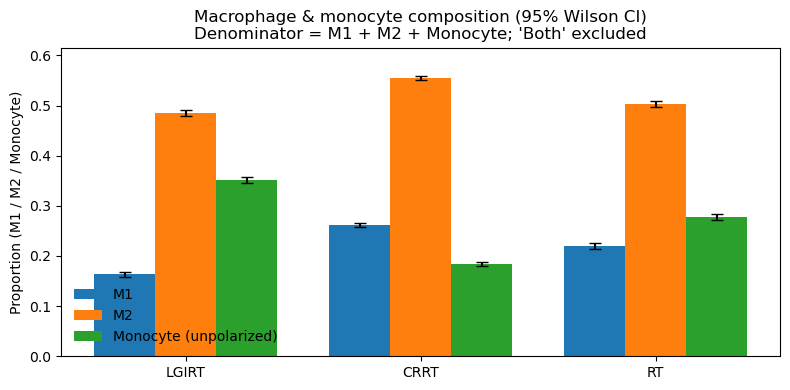

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportion_confint

order = ["LGIRT","CRRT","RT"]
den = summary3.loc[order, "denominator"].values.astype(int)

K_M1   = summary3.loc[order, "M1_sum"].values.astype(int)
K_M2   = summary3.loc[order, "M2_sum"].values.astype(int)
K_Mono = summary3.loc[order, "Mono_sum"].values.astype(int)

p_M1   = K_M1 / den
p_M2   = K_M2 / den
p_Mono = K_Mono / den

low_M1,  high_M1  = proportion_confint(K_M1,   den, alpha=0.05, method="wilson")
low_M2,  high_M2  = proportion_confint(K_M2,   den, alpha=0.05, method="wilson")
low_Mono,high_Mono= proportion_confint(K_Mono, den, alpha=0.05, method="wilson")

err_M1   = [p_M1   - low_M1,   high_M1   - p_M1]
err_M2   = [p_M2   - low_M2,   high_M2   - p_M2]
err_Mono = [p_Mono - low_Mono, high_Mono - p_Mono]

x = np.arange(len(order))
w = 0.26

plt.figure(figsize=(8,4))
plt.bar(x - w, p_M1,   width=w, yerr=err_M1,   capsize=4, label="M1")
plt.bar(x,      p_M2,   width=w, yerr=err_M2,   capsize=4, label="M2")
plt.bar(x + w,  p_Mono, width=w, yerr=err_Mono, capsize=4, label="Monocyte (unpolarized)")

plt.xticks(x, order)
plt.ylabel("Proportion (M1 / M2 / Monocyte)")
plt.title("Macrophage & monocyte composition (95% Wilson CI)\nDenominator = M1 + M2 + Monocyte; 'Both' excluded")
plt.ylim(0, max(high_M1.max(), high_M2.max(), high_Mono.max()) * 1.10)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


/tmp/ipykernel_6181/244731686.py:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  per_mouse = (ST_sample.obs.loc[den_mask, ["condition","mouse",label_col]]


Per-mouse summary (mean ± 95% CI, n_mice):
                p_M1     ci_M1      p_M2     ci_M2      p_M0     ci_M0  n_mice
condition                                                                    
LGIRT      0.231744  0.173510  0.469428  0.071547  0.298828  0.123150       3
CRRT       0.264207  0.085212  0.550568  0.071615  0.185224  0.030343       3
RT         0.228137  0.023124  0.517894  0.040312  0.253969  0.063435       2
Saved tables: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/PerMouse_M1_M2_M0_summary.csv and /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/PerMouse_M1_M2_M0_counts.csv


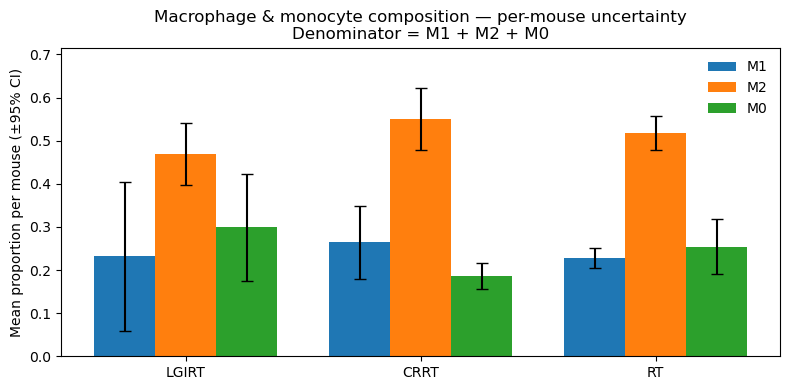

Saved figure: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/PerMouse_M1_M2_M0_barplot.png


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# where to save
outdir = "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE"
os.makedirs(outdir, exist_ok=True)

# Build per-mouse counts within the Mac/Mo denominator
label_col = "MacMono_3class"
den_mask = ST_sample.obs[label_col].isin(["M1","M2","Monocyte"])
per_mouse = (ST_sample.obs.loc[den_mask, ["condition","mouse",label_col]]
             .assign(one=1)
             .pivot_table(index=["condition","mouse"], columns=label_col, values="one",
                          aggfunc="sum", fill_value=0)
             .reindex(columns=["M1","M2","Monocyte"], fill_value=0))

per_mouse["den"] = per_mouse[["M1","M2","Monocyte"]].sum(axis=1)
per_mouse = per_mouse[per_mouse["den"] > 0]

# Per-mouse proportions
per_mouse["p_M1"] = per_mouse["M1"] / per_mouse["den"]
per_mouse["p_M2"] = per_mouse["M2"] / per_mouse["den"]
per_mouse["p_M0"] = per_mouse["Monocyte"] / per_mouse["den"]

# Summarize by condition
def mean_ci(a):
    a = np.asarray(a, float)
    m = a.mean()
    s = a.std(ddof=1) if a.size>1 else 0.0
    n = a.size
    se = s/np.sqrt(n) if n>0 else 0.0
    ci = 1.96*se
    return m, ci, n

summ = []
for cond in ["LGIRT","CRRT","RT"]:
    sub = per_mouse.loc[cond] if cond in per_mouse.index.get_level_values(0) else None
    if sub is None or isinstance(sub, pd.Series):  # single-mouse edge case
        df = sub.to_frame().T if isinstance(sub, pd.Series) else pd.DataFrame(columns=per_mouse.columns)
    else:
        df = sub
    m1_m, m1_ci, _ = mean_ci(df["p_M1"]) if len(df)>0 else (np.nan,np.nan,0)
    m2_m, m2_ci, _ = mean_ci(df["p_M2"]) if len(df)>0 else (np.nan,np.nan,0)
    m0_m, m0_ci, _ = mean_ci(df["p_M0"]) if len(df)>0 else (np.nan,np.nan,0)
    summ.append([cond, m1_m, m1_ci, m2_m, m2_ci, m0_m, m0_ci, len(df)])

summ = pd.DataFrame(summ, columns=["condition","p_M1","ci_M1","p_M2","ci_M2","p_M0","ci_M0","n_mice"]).set_index("condition")
print("Per-mouse summary (mean ± 95% CI, n_mice):\n", summ)

# Save summary tables (optional but handy)
summ_path = os.path.join(outdir, "PerMouse_M1_M2_M0_summary.csv")
per_mouse_path = os.path.join(outdir, "PerMouse_M1_M2_M0_counts.csv")
summ.to_csv(summ_path)
per_mouse.to_csv(per_mouse_path)
print("Saved tables:", summ_path, "and", per_mouse_path)

# Barplot with 95% CIs across mice
order = ["LGIRT","CRRT","RT"]
x = np.arange(len(order)); w = 0.26

plt.figure(figsize=(8,4))
plt.bar(x - w, summ.loc[order,"p_M1"], width=w, yerr=summ.loc[order,"ci_M1"], capsize=4, label="M1")
plt.bar(x,      summ.loc[order,"p_M2"], width=w, yerr=summ.loc[order,"ci_M2"], capsize=4, label="M2")
plt.bar(x + w,  summ.loc[order,"p_M0"], width=w, yerr=summ.loc[order,"ci_M0"], capsize=4, label="M0")

plt.xticks(x, order)
plt.ylabel("Mean proportion per mouse (±95% CI)")
plt.title("Macrophage & monocyte composition — per-mouse uncertainty\nDenominator = M1 + M2 + M0")
plt.ylim(0, np.nanmax([summ["p_M1"]+summ["ci_M1"], summ["p_M2"]+summ["ci_M2"], summ["p_M0"]+summ["ci_M0"]])*1.15)
plt.legend(frameon=False)
plt.tight_layout()

# SAVE FIGURE
fig_path_png = os.path.join(outdir, "PerMouse_M1_M2_M0_barplot.png")
plt.savefig(fig_path_png, dpi=300)
# plt.savefig(fig_path_png.replace(".png", ".svg"))  # optional vector version
plt.show()

print("Saved figure:", fig_path_png)


# Differential Analysis

In [11]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt

# Pick raw counts if available
X = ST_sample.layers["counts"] if "counts" in ST_sample.layers else ST_sample.X
genes = np.array(ST_sample.var_names)

# Confirm labels exist
print(ST_sample.obs["Mac_polarization_tiered"].value_counts().head())
print("Conditions:", ST_sample.obs["condition"].unique())
print("Mice:", ST_sample.obs["mouse"].nunique(), "unique mice")


Mac_polarization_tiered
Neither    266089
M2          58904
M1          21443
Both          850
Name: count, dtype: int64
Conditions: ['LGIRT', 'CRRT', 'RT']
Categories (3, object): ['CRRT', 'LGIRT', 'RT']
Mice: 8 unique mice


In [12]:
# # Use only cells labeled M2. If you previously restricted to Mac/Mono, it's fine—M2 label already implies that.
# m2_mask = (ST_sample.obs["Mac_polarization_tiered"] == "M2")
# m2_obs = ST_sample.obs.loc[m2_mask, ["condition","mouse"]]

# # Group indices per (condition, mouse)
# groups = m2_obs.groupby(["condition","mouse"]).indices
# print("Pseudobulk groups (cond, mouse):", len(groups))

# # Build count matrix: samples = mouse×condition, features = genes
# sample_keys = list(groups.keys())
# n_samples = len(sample_keys)
# n_genes = ST_sample.n_vars

# # Sum counts per group
# if sp.issparse(X):
#     X_csr = X.tocsr()
# else:
#     X_csr = sp.csr_matrix(X)  # cast to sparse for fast row slicing/sum

# pb_counts = np.zeros((n_samples, n_genes), dtype=np.float64)
# n_cells = np.zeros(n_samples, dtype=int)

# for i, key in enumerate(sample_keys):
#     idx = groups[key]
#     block = X_csr[idx, :]
#     pb_counts[i, :] = np.array(block.sum(axis=0)).ravel()
#     n_cells[i] = len(idx)

# # Sample metadata
# pb_meta = pd.DataFrame(sample_keys, columns=["condition","mouse"])
# pb_meta["sample_id"] = pb_meta["condition"] + "__" + pb_meta["mouse"].astype(str)
# pb_meta["n_cells"] = n_cells
# pb_libsize = pb_counts.sum(axis=1)
# pb_meta["libsize"] = pb_libsize

# print(pb_meta.head())


In [13]:
# # Build sample_keys sorted by condition, then mouse
# sample_keys = sorted(list(groups.keys()), key=lambda t: (str(t[0]), str(t[1])))
# pb_meta = pd.DataFrame(sample_keys, columns=["condition","mouse"])
# pb_meta["sample_id"] = pb_meta["condition"] + "__" + pb_meta["mouse"].astype(str)
# pb_meta["n_cells"] = [len(groups[k]) for k in sample_keys]
# pb_meta["libsize"] = [np.array(X_csr[groups[k], :].sum(axis=0)).ravel().sum() for k in sample_keys]

# display(pb_meta)
# print(pb_meta["condition"].value_counts())

In [14]:
# # How many M2 cells per condition × mouse?
# m2_mask = (ST_sample.obs["Mac_polarization_tiered"] == "M2")
# m2_counts_per_mouse = (ST_sample.obs.loc[m2_mask, ["condition","mouse"]]
#                        .groupby(["condition","mouse"]).size().rename("n_M2"))
# print(m2_counts_per_mouse.sort_index())

# # After building pb_meta above:
# print("\nPseudobulk counts by condition (from pb_meta):")
# print(pb_meta["condition"].value_counts())

# print("\nAll pseudobulk rows, sorted:")
# display(pb_meta.sort_values(["condition","mouse"]).reset_index(drop=True))


In [15]:
import numpy as np, pandas as pd, scipy.sparse as sp

# Matrix & genes
X = ST_sample.layers["counts"] if "counts" in ST_sample.layers else ST_sample.X
genes = np.array(ST_sample.var_names)

# M2 mask
m2_mask = (ST_sample.obs["Mac_polarization_tiered"] == "M2")

# Work on a copy; if columns are categorical, drop unused levels
m2_obs = ST_sample.obs.loc[m2_mask, ["condition","mouse"]].copy()
if pd.api.types.is_categorical_dtype(m2_obs["condition"]):
    m2_obs["condition"] = m2_obs["condition"].cat.remove_unused_categories()
if pd.api.types.is_categorical_dtype(m2_obs["mouse"]):
    m2_obs["mouse"] = m2_obs["mouse"].cat.remove_unused_categories()

# Counts per condition×mouse — ONLY observed pairs
m2_counts_per_mouse = (m2_obs
                       .groupby(["condition","mouse"], observed=True)
                       .size()
                       .rename("n_M2")
                       .sort_index())
print("M2 cells per condition×mouse (observed only):")
print(m2_counts_per_mouse)

# Build pseudobulk groups (again observed=True avoids empty pairs)
groups = m2_obs.groupby(["condition","mouse"], observed=True).indices
print("\n# Pseudobulk groups:", len(groups))

# Prepare sparse for fast sum
X_csr = X.tocsr() if sp.issparse(X) else sp.csr_matrix(X)

# Sorted keys so RT shows up clearly
sample_keys = sorted(groups.keys(), key=lambda t: (str(t[0]), str(t[1])))

# Sum counts per group
pb_counts = np.zeros((len(sample_keys), ST_sample.n_vars), dtype=np.float64)
n_cells   = np.zeros(len(sample_keys), dtype=int)
for i, key in enumerate(sample_keys):
    idx = groups[key]
    block = X_csr[idx, :]
    pb_counts[i, :] = np.array(block.sum(axis=0)).ravel()
    n_cells[i] = len(idx)

# Metadata
pb_meta = pd.DataFrame(sample_keys, columns=["condition","mouse"])
pb_meta["sample_id"] = pb_meta["condition"] + "__" + pb_meta["mouse"].astype(str)
pb_meta["n_cells"]   = n_cells
pb_meta["libsize"]   = pb_counts.sum(axis=1)

# Show all rows, sorted — you should see RT rows here
display(pb_meta.sort_values(["condition","mouse"]).reset_index(drop=True))
print("\nPseudobulks by condition:\n", pb_meta["condition"].value_counts())


M2 cells per condition×mouse (observed only):
condition  mouse   
CRRT       36_CRRT      9440
           37_CRRT      7806
           38_CRRT     13699
LGIRT      33_LGIRT      879
           34_LGIRT     6394
           35_LGIRT     7497
RT         31_RT       11371
           32_RT        1818
Name: n_M2, dtype: int64

# Pseudobulk groups: 8


/tmp/ipykernel_6181/3121687097.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(m2_obs["condition"]):
/tmp/ipykernel_6181/3121687097.py:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(m2_obs["mouse"]):


,condition,mouse,sample_id,n_cells,libsize
0,CRRT,36_CRRT,CRRT__36_CRRT,9440,1405929.0
1,CRRT,37_CRRT,CRRT__37_CRRT,7806,1292232.0
2,CRRT,38_CRRT,CRRT__38_CRRT,13699,2021825.0
3,LGIRT,33_LGIRT,LGIRT__33_LGIRT,879,139091.0
4,LGIRT,34_LGIRT,LGIRT__34_LGIRT,6394,948570.0
5,LGIRT,35_LGIRT,LGIRT__35_LGIRT,7497,1228256.0
6,RT,31_RT,RT__31_RT,11371,1815757.0
7,RT,32_RT,RT__32_RT,1818,275255.0



Pseudobulks by condition:
 condition
CRRT     3
LGIRT    3
RT       2
Name: count, dtype: int64


In [16]:
# CPM (row-wise library sizes)
libsize = pb_meta["libsize"].values.astype(float)            # shape (n_samples,)
libsize_col = libsize[:, None]                               # shape (n_samples, 1)

# Optional: drop pseudobulks with zero or tiny libsize (e.g., no M2 cells)
keep = libsize > 0
if (~keep).any():
    print("Dropping", (~keep).sum(), "pseudobulk(s) with zero library size")
    pb_counts = pb_counts[keep, :]
    libsize_col = libsize_col[keep, :]
    pb_meta = pb_meta.loc[keep].reset_index(drop=True)

# Recompute for safety
libsize_col = pb_meta["libsize"].values.astype(float)[:, None]

# CPM and log2-CPM
cpm = (pb_counts * 1e6) / np.maximum(libsize_col, 1.0)       # broadcasting now works
logcpm = np.log2(cpm + 1.0)

logcpm_df = pd.DataFrame(logcpm, index=pb_meta["sample_id"], columns=genes)
logcpm_df.head()


,Xkr4,Rp1,Sox17,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,Npbwr1,Rb1cc1,...,mt-Atp8,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,Vamp7
sample_id,,,,,,,,,,,,,,,,,,,,,
CRRT__36_CRRT,0.000000,0.000000,3.020188,5.782848,7.259390,1.647923,8.025775,1.276525,0.0,5.890554,...,10.825553,10.941752,11.447470,8.076075,8.974871,9.654925,9.585834,7.441612,11.008026,5.706301
CRRT__37_CRRT,0.000000,0.000000,1.349201,6.292515,7.366823,1.731863,8.102997,0.000000,0.0,5.636707,...,10.915128,11.095850,11.547243,8.146986,9.079887,9.640372,9.567203,7.550739,11.126136,5.744757
CRRT__38_CRRT,0.000000,0.579762,3.985325,5.973274,7.301853,1.988272,8.017825,0.000000,0.0,5.599373,...,10.833364,10.956612,11.466903,8.042393,8.963084,9.611896,9.517693,7.628277,11.045045,5.830106
LGIRT__33_LGIRT,3.033782,0.000000,0.000000,5.870767,7.177826,0.000000,8.208337,0.000000,0.0,6.447488,...,10.896505,11.247372,11.688686,7.852156,8.849031,9.602643,9.801713,7.497760,11.122671,5.463924
LGIRT__34_LGIRT,0.000000,0.000000,2.872890,5.981827,7.476614,2.057504,8.136592,1.038590,0.0,5.244036,...,10.817597,10.947269,11.430946,8.018387,8.892993,9.591772,9.506519,7.622671,10.931781,5.882203


In [17]:
min_cells = 10   # adjust to your comfort level (e.g., 10–50)
keep_cells = pb_meta["n_cells"].values >= min_cells
if (~keep_cells).any():
    print("Dropping", (~keep_cells).sum(), "pseudobulk(s) with <", min_cells, "M2 cells")
    pb_counts = pb_counts[keep_cells, :]
    pb_meta = pb_meta.loc[keep_cells].reset_index(drop=True)


pb_counts shape: (8, 19059)
pb_meta rows   : 8
logcpm shape: (8, 19059)

Contrast LGIRT vs CRRT: nA=3, nB=3
  Saved full DE table: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/LGIRT_vs_CRRT/DE_M2_LGIRT_vs_CRRT.csv
  Saved tops: DE_M2_topUP_in_LGIRT_vs_CRRT.csv and DE_M2_topDOWN_in_LGIRT_vs_CRRT.csv


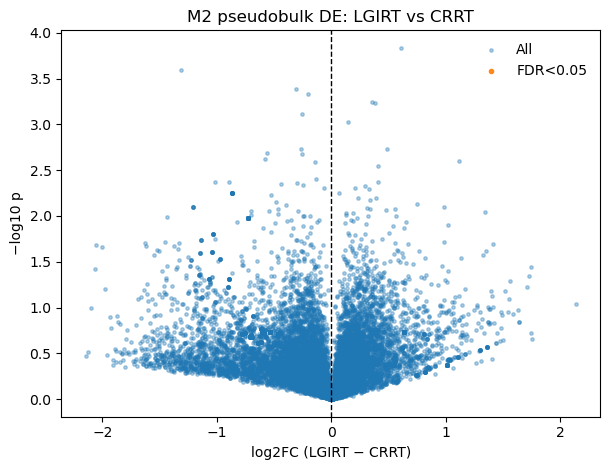

  Saved volcano: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/LGIRT_vs_CRRT/Volcano_M2_LGIRT_vs_CRRT.png

Contrast LGIRT vs RT: nA=3, nB=2
  Saved full DE table: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/LGIRT_vs_RT/DE_M2_LGIRT_vs_RT.csv
  Saved tops: DE_M2_topUP_in_LGIRT_vs_RT.csv and DE_M2_topDOWN_in_LGIRT_vs_RT.csv


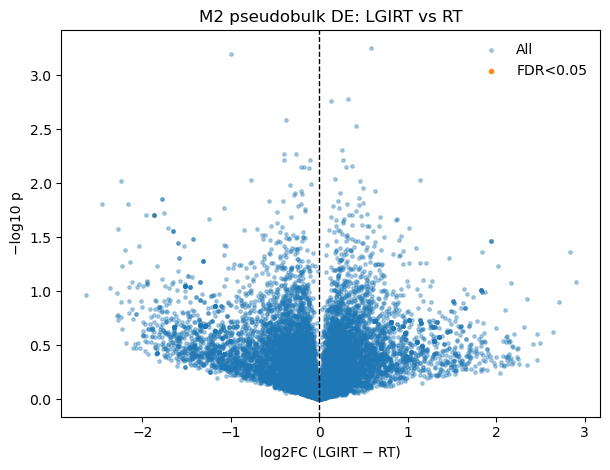

  Saved volcano: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/LGIRT_vs_RT/Volcano_M2_LGIRT_vs_RT.png

Contrast CRRT vs RT: nA=3, nB=2
  Saved full DE table: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/CRRT_vs_RT/DE_M2_CRRT_vs_RT.csv
  Saved tops: DE_M2_topUP_in_CRRT_vs_RT.csv and DE_M2_topDOWN_in_CRRT_vs_RT.csv


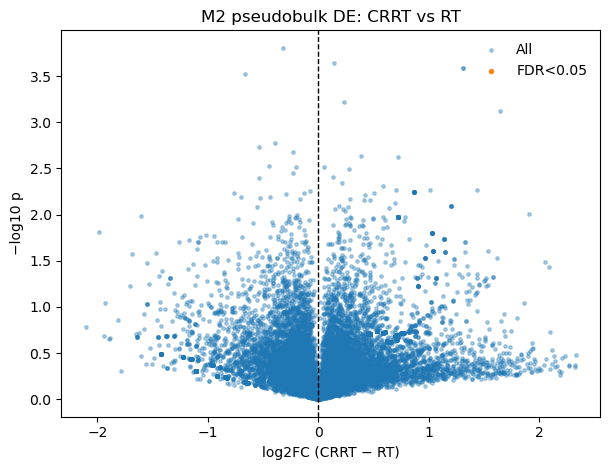

  Saved volcano: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/CRRT_vs_RT/Volcano_M2_CRRT_vs_RT.png


In [18]:
# --- paths ---
outdir = "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE"
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm

os.makedirs(outdir, exist_ok=True)

# --- sanity: pb_counts and pb_meta must be aligned before CPM ---
print("pb_counts shape:", pb_counts.shape)
print("pb_meta rows   :", pb_meta.shape[0])
assert pb_counts.shape[0] == pb_meta.shape[0], "pb_counts and pb_meta out of sync"

# --- CPM + logCPM (row-wise) ---
genes = np.array(ST_sample.var_names)
libsize = pb_meta["libsize"].values.astype(float)[:, None]   # (n_samples, 1)

cpm = (pb_counts * 1e6) / np.maximum(libsize, 1.0)
logcpm = np.log2(cpm + 1.0)

# Quick check
n_samples, n_genes = logcpm.shape
print("logcpm shape:", logcpm.shape)
assert n_samples == pb_meta.shape[0], "logcpm rows must equal pb_meta rows"

# --- contrasts with robust masking/guards ---
contrasts = [("LGIRT","CRRT"), ("LGIRT","RT"), ("CRRT","RT")]
de_results = {}

for A, B in contrasts:
    iA = (pb_meta["condition"].values == A)   # boolean array length n_samples
    iB = (pb_meta["condition"].values == B)

    nA, nB = iA.sum(), iB.sum()
    print(f"\nContrast {A} vs {B}: nA={nA}, nB={nB}")

    # guard: need at least 2 pseudobulks per group for a t-test
    if nA < 2 or nB < 2:
        print(f"  Skipping {A} vs {B}: need >=2 samples per group after filtering.")
        continue

    XA = logcpm[iA, :]
    XB = logcpm[iB, :]

    # Welch’s t-test per gene
    t_stat = np.empty(n_genes); pval = np.empty(n_genes)
    for g in range(n_genes):
        t, p = ttest_ind(XA[:, g], XB[:, g], equal_var=False, nan_policy="omit")
        t_stat[g] = t; pval[g] = p

    l2fc = XA.mean(axis=0) - XB.mean(axis=0)  # mean difference on log2-CPM scale
    _, qval, _, _ = smm.multipletests(pval, method="fdr_bh")

    res = pd.DataFrame({
        "gene": genes,
        "log2FC": l2fc,
        "t": t_stat,
        "pval": pval,
        "qval": qval,
        f"mean_logCPM_{A}": XA.mean(axis=0),
        f"mean_logCPM_{B}": XB.mean(axis=0),
        f"n_{A}": nA,
        f"n_{B}": nB
    }).sort_values("qval")
    de_results[(A,B)] = res

    # --- save tables ---
    contrast_dir = os.path.join(outdir, f"{A}_vs_{B}")
    os.makedirs(contrast_dir, exist_ok=True)

    full_csv = os.path.join(contrast_dir, f"DE_M2_{A}_vs_{B}.csv")
    res.to_csv(full_csv, index=False)
    print("  Saved full DE table:", full_csv)

    # Top UP in A and DOWN in A (by FDR<0.05; fallback to top 200 by pval if none pass)
    up_sig = res[(res["log2FC"] > 0) & (res["qval"] < 0.05)]
    dn_sig = res[(res["log2FC"] < 0) & (res["qval"] < 0.05)]

    if up_sig.empty:
        up_sig = res[res["log2FC"] > 0].sort_values("pval").head(200)
    if dn_sig.empty:
        dn_sig = res[res["log2FC"] < 0].sort_values("pval").head(200)

    up_csv = os.path.join(contrast_dir, f"DE_M2_topUP_in_{A}_vs_{B}.csv")
    dn_csv = os.path.join(contrast_dir, f"DE_M2_topDOWN_in_{A}_vs_{B}.csv")
    up_sig.to_csv(up_csv, index=False)
    dn_sig.to_csv(dn_csv, index=False)
    print("  Saved tops:", os.path.basename(up_csv), "and", os.path.basename(dn_csv))

    # --- volcano plot (save PNG) ---
    x = res["log2FC"].to_numpy()
    y = -np.log10(np.clip(res["pval"].to_numpy(), 1e-300, 1.0))
    sig = res["qval"].to_numpy() < 0.05

    plt.figure(figsize=(6.2,4.8))
    plt.scatter(x, y, s=6, alpha=0.35, label="All")
    plt.scatter(x[sig], y[sig], s=9, alpha=0.9, label="FDR<0.05")
    plt.axvline(0, ls="--", c="k", lw=1)
    plt.xlabel(f"log2FC ({A} − {B})")
    plt.ylabel("−log10 p")
    plt.title(f"M2 pseudobulk DE: {A} vs {B}")
    plt.legend(frameon=False, loc="upper right")
    plt.tight_layout()

    volcano_png = os.path.join(contrast_dir, f"Volcano_M2_{A}_vs_{B}.png")
    plt.savefig(volcano_png, dpi=300)
    plt.show()
    print("  Saved volcano:", volcano_png)


In [19]:
# If gseapy isn't installed, uncomment the next line:
# %pip install -q gseapy

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gseapy as gp

GENESET_GMT = "/mnt/c/Users/jonan/Documents/1Work/RoseLab/References/mh.all.v2025.1.Mm.symbols.gmt"

assert os.path.exists(GENESET_GMT), f"Can't find {GENESET_GMT}. Point to a local .gmt file."

In [32]:
# expects `de_results` from your DE step:
# keys like ("LGIRT","CRRT"), values = DataFrame with columns ["gene","log2FC","pval","qval",...]

# outdir = "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE"
# os.makedirs(outdir, exist_ok=True)

/tmp/ipykernel_6181/2548064147.py:23: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(
2025-09-19 22:50:49,660 [WARNING] Duplicated values found in preranked stats: 33.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.



=== GSEA (prerank): LGIRT vs CRRT ===
  Saved: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/GSEA_LGIRT_vs_CRRT/GSEA_results.csv

  Top UP in LGIRT (NES highest):
                         term       nes fdr_q_val
2     cholesterol_homeostasis   1.31156  0.191489
6             spermatogenesis  1.207734  0.292553
15  unfolded_protein_response  1.034774  0.719858
37          protein_secretion  0.721817       1.0
42             myc_targets_v2  0.630513       1.0
47             myc_targets_v1     0.535       1.0
49  oxidative_phosphorylation -0.395883       1.0
48                    hypoxia  -0.50215       1.0
46                 glycolysis -0.564274       1.0
45                  apoptosis -0.571872       1.0

  Top DOWN in LGIRT (NES lowest):
                                 term       nes fdr_q_val
0                        angiogenesis -1.477136  0.251802
1                 il2_stat5_

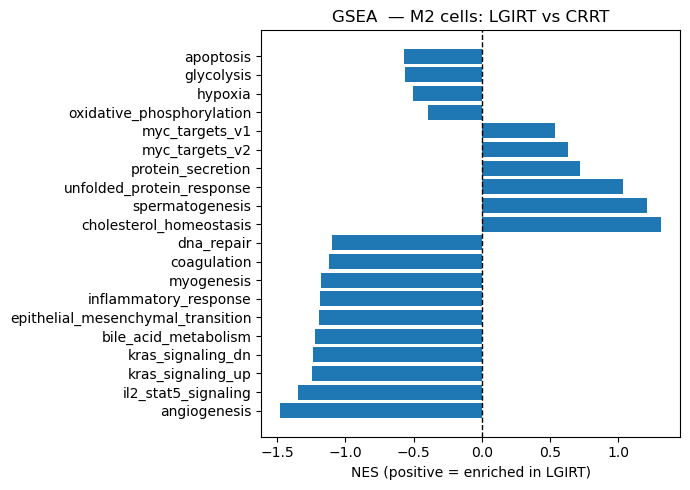

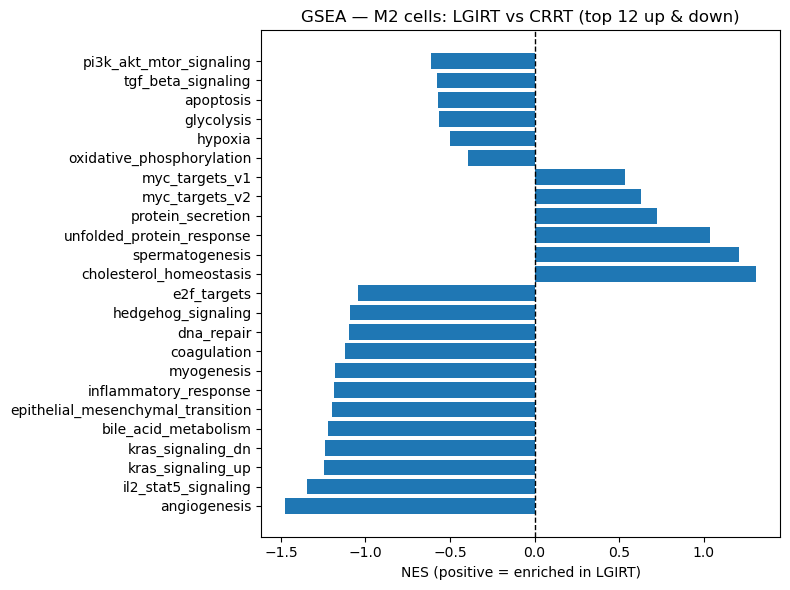

  Saved: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/GSEA_LGIRT_vs_CRRT/GSEA_LGIRT_vs_CRRT_NES_combined_top12.png


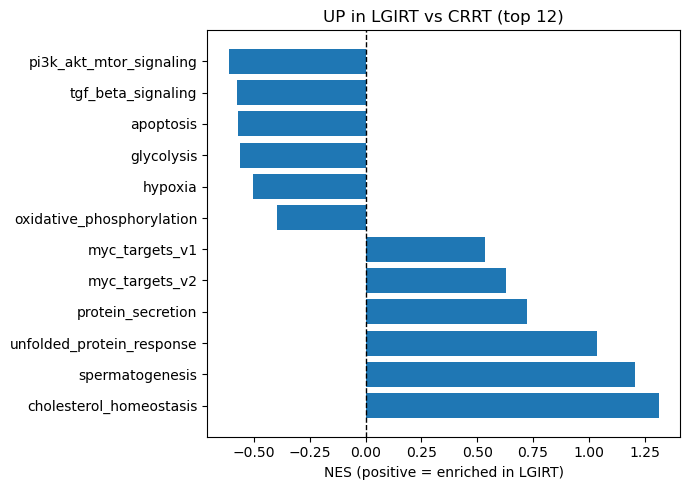

  Saved: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/GSEA_LGIRT_vs_CRRT/GSEA_LGIRT_vs_CRRT_UP_in_LGIRT_top12.png


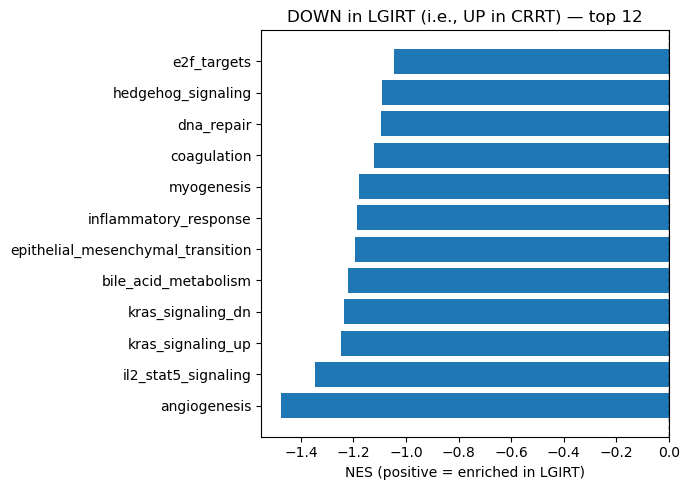

/tmp/ipykernel_6181/2548064147.py:23: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(
2025-09-19 22:50:51,540 [WARNING] Duplicated values found in preranked stats: 38.32% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


  Saved: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/GSEA_LGIRT_vs_CRRT/GSEA_LGIRT_vs_CRRT_DOWN_in_LGIRT_top12.png

=== GSEA (prerank): LGIRT vs RT ===
  Saved: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/GSEA_LGIRT_vs_RT/GSEA_results.csv

  Top UP in LGIRT (NES highest):
                          term       nes fdr_q_val
7   wnt_beta_catenin_signaling  1.136291       1.0
13             apical_junction  1.010292       1.0
17          hedgehog_signaling  0.918641       1.0
19              apical_surface  0.903799       1.0
22                  glycolysis  0.873487       1.0
23   interferon_alpha_response  0.869186       1.0
24              g2m_checkpoint  0.865256       1.0
26   unfolded_protein_response  0.863491       1.0
27                     hypoxia  0.848687       1.0

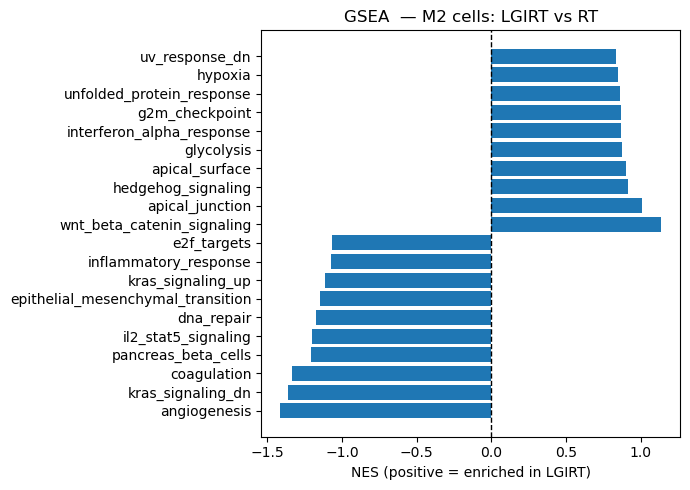

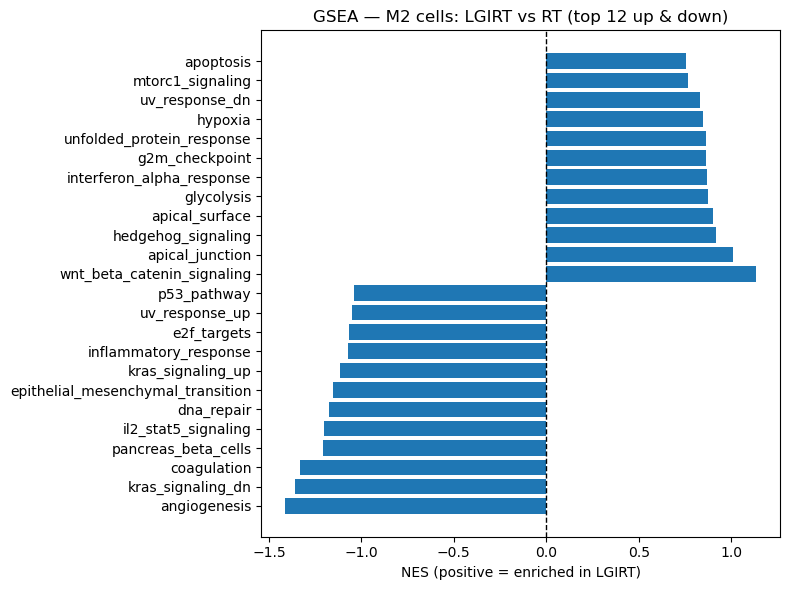

  Saved: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/GSEA_LGIRT_vs_RT/GSEA_LGIRT_vs_RT_NES_combined_top12.png


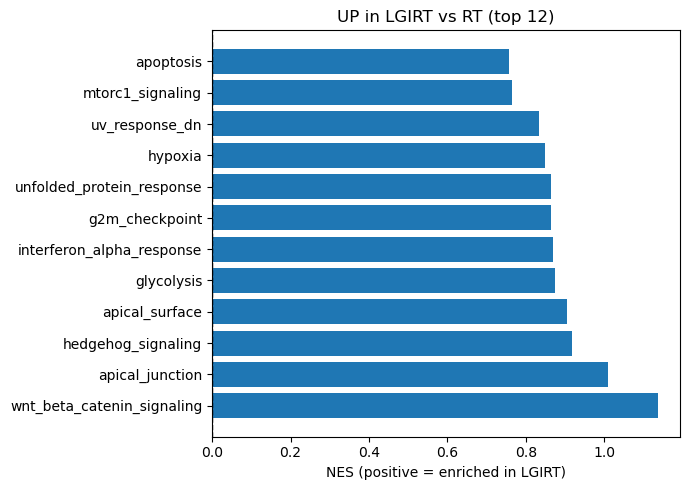

  Saved: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/GSEA_LGIRT_vs_RT/GSEA_LGIRT_vs_RT_UP_in_LGIRT_top12.png


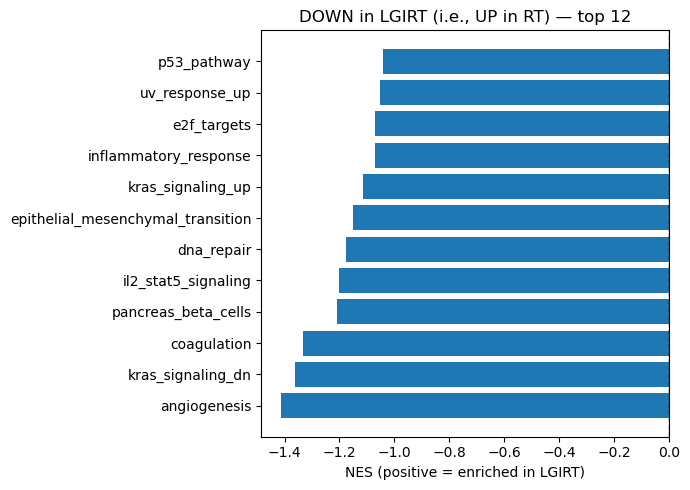

/tmp/ipykernel_6181/2548064147.py:23: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(
2025-09-19 22:50:53,081 [WARNING] Duplicated values found in preranked stats: 35.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


  Saved: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/GSEA_LGIRT_vs_RT/GSEA_LGIRT_vs_RT_DOWN_in_LGIRT_top12.png

=== GSEA (prerank): CRRT vs RT ===
  Saved: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/GSEA_CRRT_vs_RT/GSEA_results.csv

  Top UP in CRRT (NES highest):
                          term       nes fdr_q_val
0   wnt_beta_catenin_signaling  1.415262  0.670365
1           hedgehog_signaling  1.388528  0.437401
2               apical_surface  1.267401  0.952456
4        inflammatory_response  1.200101       1.0
6          allograft_rejection  1.154726       1.0
7              apical_junction  1.151075       1.0
8                   myogenesis  1.148591       1.0
9               uv_response_dn  1.122727       1.0
10        bile_acid_metabolism  1.117349       1.0
11   i

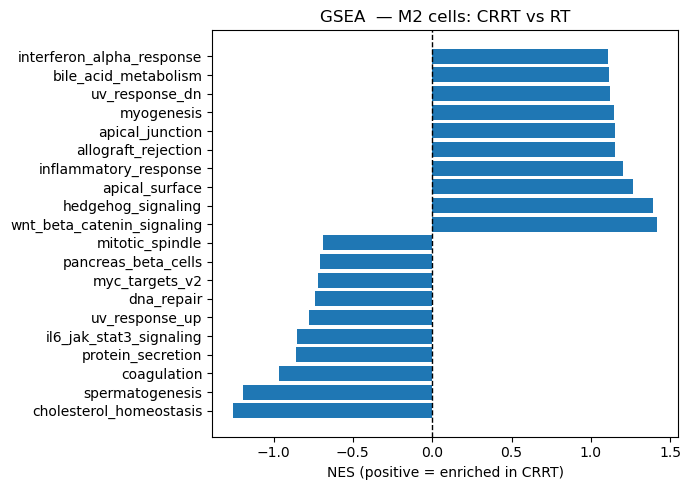

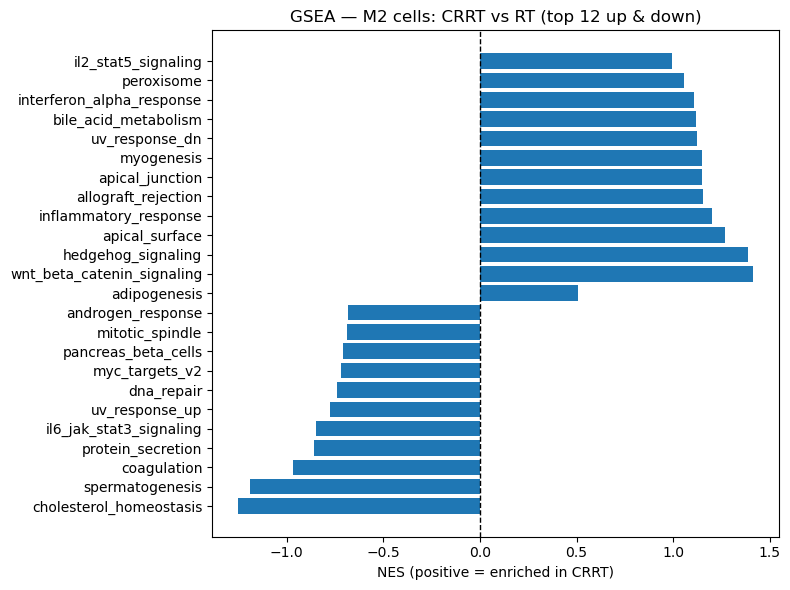

  Saved: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/GSEA_CRRT_vs_RT/GSEA_CRRT_vs_RT_NES_combined_top12.png


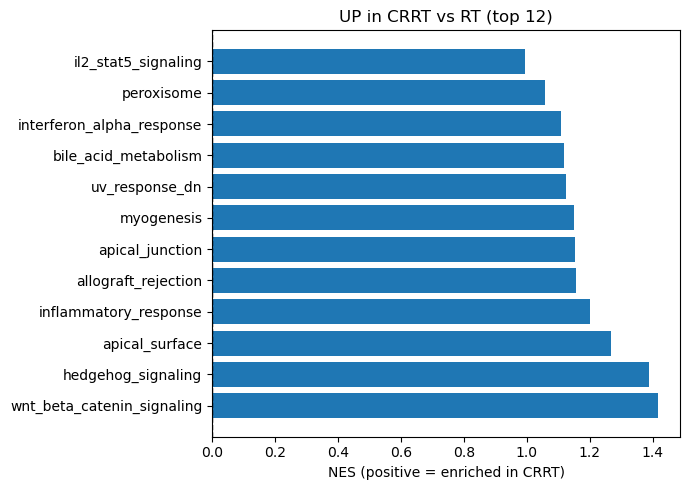

  Saved: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/GSEA_CRRT_vs_RT/GSEA_CRRT_vs_RT_UP_in_CRRT_top12.png


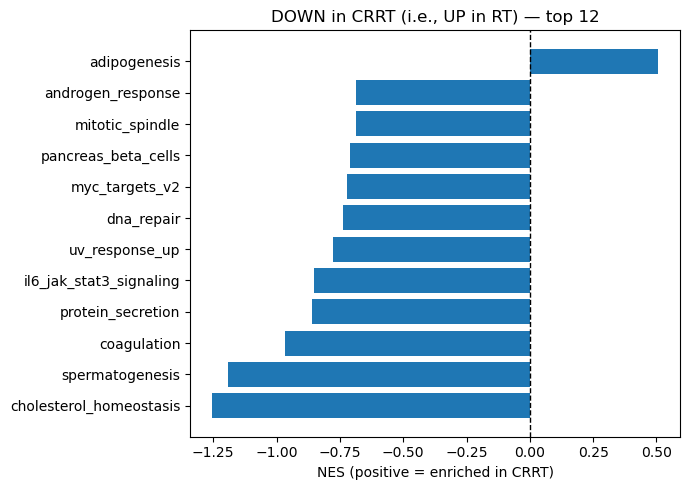

  Saved: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/GSEA_CRRT_vs_RT/GSEA_CRRT_vs_RT_DOWN_in_CRRT_top12.png


In [22]:
# expects: de_results, GENESET_GMT, outdir, and gseapy as gp already imported
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

gsea_outputs = {}

for (A,B), de in de_results.items():
    print(f"\n=== GSEA (prerank): {A} vs {B} ===")

    # Build ranking table
    rnk = (de[["gene","log2FC"]]
           .dropna()
           .drop_duplicates(subset="gene", keep="first")
           .sort_values("log2FC", ascending=False))

    if rnk["log2FC"].abs().sum() == 0 or len(rnk) < 50:
        print("  Skipping: insufficient ranking signal or too few genes.")
        continue

    pr_outdir = os.path.join(outdir, f"GSEA_{A}_vs_{B}")
    pre_res = gp.prerank(
        rnk=rnk,
        gene_sets=GENESET_GMT,
        processes=4,
        permutation_num=200,
        seed=42,
        outdir=pr_outdir,
        format="png"
    )

    
    # Normalize column names (keep this as-is)
    res = pre_res.res2d.copy()
    res.columns = [c.lower().replace(" ", "_").replace("-", "_") for c in res.columns]
    
    # >>> ADD THIS BLOCK <<<
    # Clean pathway names: drop "hallmark" prefix, lowercase (optional: turn "_" into " ")
    if "term" in res.columns:
        res["term_clean"] = (
            res["term"]
            .str.replace(r"^hallmark[_ ]", "", case=False, regex=True)
            .str.lower()
            # .str.replace("_", " ")  # uncomment if you want spaces instead of underscores
        )
    else:
        res["term_clean"] = res.columns[0]  # very rare fallback
    # <<< END ADD >>>
    
    # FDR column detection (keep your existing logic)
    fdr_col_candidates = ["fdr", "fdr_q_val", "fdr_qval", "fdr_bh", "padj", "qval"]
    fdr_col = next((c for c in fdr_col_candidates if c in res.columns), None)
    sort_col = "pval" if (fdr_col is None and "pval" in res.columns) else (fdr_col or res.columns[0])
    
    # Ensure NES exists (keep your existing logic)
    if "nes" not in res.columns:
        if "normalized_enrichment_score" in res.columns:
            res["nes"] = res["normalized_enrichment_score"]
        elif "es" in res.columns:
            res["nes"] = res["es"]
        else:
            res["nes"] = -np.log10(res[sort_col]) if sort_col in res.columns else 0.0
    
    # Save full results (now includes both original 'term' and 'term_clean')
    csv_path = os.path.join(pr_outdir, "GSEA_results.csv")
    res.sort_values(sort_col, inplace=True)
    res.to_csv(csv_path, index=False)
    print("  Saved:", csv_path)
    
    # >>> CHANGE THESE TWO LINES TO USE 'term_clean' FOR DISPLAY <<<
    show_cols = [c for c in ["term_clean","nes","pval",fdr_col] if c in res.columns]
    top_up = res.sort_values("nes", ascending=False).head(10)
    top_dn = res.sort_values("nes", ascending=True).head(10)
    
    print("\n  Top UP in", A, "(NES highest):")
    print(top_up[show_cols].rename(columns={"term_clean": "term"}))
    
    print("\n  Top DOWN in", A, "(NES lowest):")
    print(top_dn[show_cols].rename(columns={"term_clean": "term"}))
    
    gsea_outputs[(A,B)] = res
    
    # Plot with cleaned labels
    plot_df = pd.concat([top_dn, top_up], axis=0)
    plt.figure(figsize=(7,5))
    y = np.arange(len(plot_df))
    plt.barh(y, plot_df["nes"].values)
    plt.yticks(y, plot_df["term_clean"].values)  # cleaned names here
    plt.axvline(0, ls="--", c="k", lw=1)
    plt.xlabel(f"NES (positive = enriched in {A})")
    plt.title(f"GSEA  — M2 cells: {A} vs {B}")
    plt.tight_layout()
    plt.show()

        # Choose how many pathways to show
    top_k = 12  # edit as you like
    
    # Split into up/down (relative to A)
    top_up = res.sort_values("nes", ascending=False).head(top_k)    # up in A
    top_dn = res.sort_values("nes", ascending=True).head(top_k)     # down in A (i.e., up in B)
    
    # 0) Combined NES plot (up + down together)
    plot_df = pd.concat([top_dn, top_up], axis=0)
    plt.figure(figsize=(8,6))
    y = np.arange(len(plot_df))
    plt.barh(y, plot_df["nes"].values)
    plt.yticks(y, plot_df["term_clean"].values)
    plt.axvline(0, ls="--", c="k", lw=1)
    plt.xlabel(f"NES (positive = enriched in {A})")
    plt.title(f"GSEA — M2 cells: {A} vs {B} (top {top_k} up & down)")
    plt.tight_layout()
    # SAVE
    comb_path_png = os.path.join(pr_outdir, f"GSEA_{A}_vs_{B}_NES_combined_top{top_k}.png")
    plt.savefig(comb_path_png, dpi=300)
    # plt.savefig(comb_path_png.replace(".png",".svg"))  # optional vector
    plt.show()
    print("  Saved:", comb_path_png)
    
    # 1) UPregulated figure (enriched in A; positive NES)
    plt.figure(figsize=(7,5))
    y_up = np.arange(len(top_up))
    plt.barh(y_up, top_up["nes"].values)
    plt.yticks(y_up, top_up["term_clean"].values)
    plt.axvline(0, ls="--", c="k", lw=1)
    plt.xlabel(f"NES (positive = enriched in {A})")
    plt.title(f"UP in {A} vs {B} (top {top_k})")
    plt.tight_layout()
    up_path_png = os.path.join(pr_outdir, f"GSEA_{A}_vs_{B}_UP_in_{A}_top{top_k}.png")
    plt.savefig(up_path_png, dpi=300)
    # plt.savefig(up_path_png.replace(".png",".svg"))
    plt.show()
    print("  Saved:", up_path_png)
    
    # 2) DOWNregulated figure (enriched in B; negative NES)
    plt.figure(figsize=(7,5))
    y_dn = np.arange(len(top_dn))
    plt.barh(y_dn, top_dn["nes"].values)
    plt.yticks(y_dn, top_dn["term_clean"].values)
    plt.axvline(0, ls="--", c="k", lw=1)
    plt.xlabel(f"NES (positive = enriched in {A})")
    plt.title(f"DOWN in {A} (i.e., UP in {B}) — top {top_k}")
    plt.tight_layout()
    down_path_png = os.path.join(pr_outdir, f"GSEA_{A}_vs_{B}_DOWN_in_{A}_top{top_k}.png")
    plt.savefig(down_path_png, dpi=300)
    # plt.savefig(down_path_png.replace(".png",".svg"))
    plt.show()
    print("  Saved:", down_path_png)


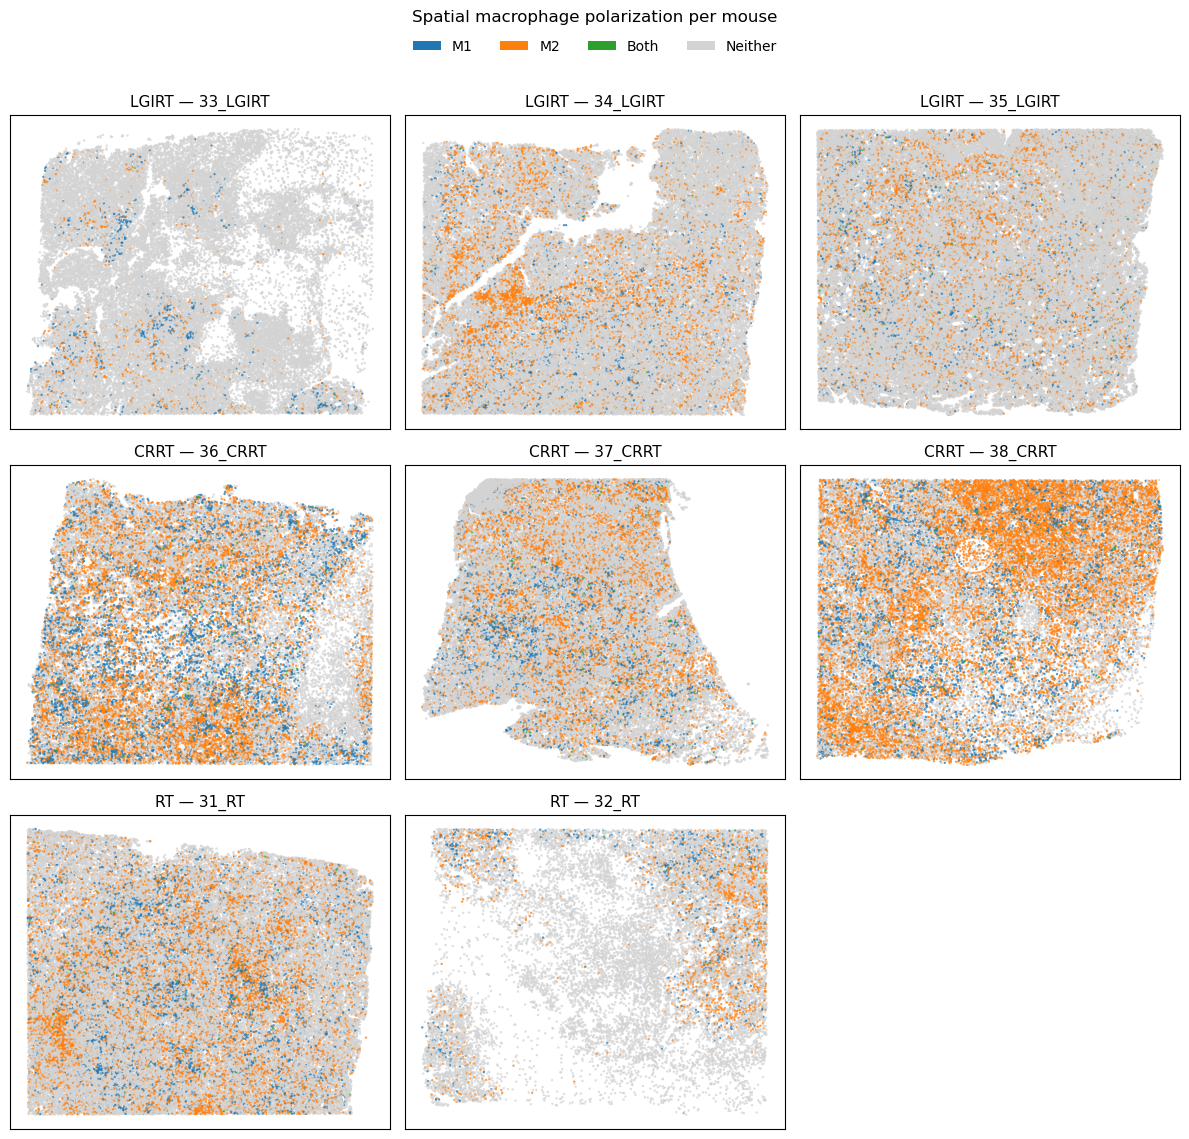

Saved figure: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE/Spatial_M1_M2_M0_by_mouse.png


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

assert "spatial" in ST_sample.obsm_keys(), "No ST_sample.obsm['spatial'] found."
coords = ST_sample.obsm["spatial"]
pol    = ST_sample.obs["Mac_polarization_tiered"]
conds  = ST_sample.obs["condition"]
mice   = ST_sample.obs["mouse"]  # must exist

order_cond = ["LGIRT","CRRT","RT"]
color_map = {"M1":"tab:blue","M2":"tab:orange","Both":"tab:green","Neither":"lightgray"}

# collect mice per condition (deterministic order)
mice_per_cond = {c: sorted(ST_sample.obs.loc[conds==c, "mouse"].unique().tolist())
                 for c in order_cond}

# number of columns = max # mice across the three rows
ncols = max(len(v) for v in mice_per_cond.values())
nrows = len(order_cond)

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.8*nrows), sharex=False, sharey=False)

# axes always 2D for easy indexing
if nrows == 1:
    axes = np.array([axes])
if ncols == 1:
    axes = axes.reshape(nrows, 1)

for r, cond in enumerate(order_cond):
    row_mice = mice_per_cond[cond]
    for c in range(ncols):
        ax = axes[r, c]
        if c < len(row_mice):
            m = row_mice[c]
            mask = (conds==cond).values & (mice==m).values
            if mask.sum() == 0:
                ax.axis("off")
                continue

            # scatter
            ax.scatter(coords[mask,0], coords[mask,1], s=3,
                       c=pol[mask].map(color_map).values, alpha=0.75, linewidths=0)

            ax.set_title(f"{cond} — {m}", fontsize=11)
            ax.invert_yaxis()
            ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(True)
        else:
            ax.axis("off")

# legend
from matplotlib.patches import Patch
handles = [Patch(facecolor=color_map[k], edgecolor='none', label=k) 
           for k in ["M1","M2","Both","Neither"]]
fig.legend(handles=handles, loc="upper center", ncol=4, frameon=False, bbox_to_anchor=(0.5, 0.98))

plt.suptitle("Spatial macrophage polarization per mouse", y=0.995)
plt.tight_layout(rect=[0,0,1,0.96])  # leave space for legend

import os
outdir = "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/results/Differential_Analysis/M1_M2_analysis_Rosepresentation9.19.25/m2_pseudobulk_DE"
os.makedirs(outdir, exist_ok=True)
png_path = os.path.join(outdir, "Spatial_M1_M2_M0_by_mouse.png")
fig.savefig(png_path, dpi=300)            # PNG
# fig.savefig(png_path.replace(".png",".svg"))  # optional vector/SVG

plt.show()
print("Saved figure:", png_path)

plt.show()
